In [2]:
import pandas as pd
# Load the dataset
df = pd.read_csv('cleaned_dataset.csv')
# Basic Data Checks (EDA)
print("--- Data Information and Checks (EDA) ---")
print(f"DataFrame Shape: {df.shape}")
print("\nDataFrame Info:")
df.info()

print("\nMissing Value Count (Should be zero for key columns):")
print(df.isnull().sum())

print("\nDescriptive Statistics (Numerical):")
print(df.describe())

--- Data Information and Checks (EDA) ---
DataFrame Shape: (9551, 21)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df.dropna(subset=['Cuisines'], inplace=True)

# Filter Cuisines: Keeping only those that appear 2 or more times
min_occurrence = 2
all_cuisines_list = df['Cuisines'].str.split(', ').explode()
cuisine_counts = all_cuisines_list.value_counts()
valid_cuisines = cuisine_counts[cuisine_counts >= min_occurrence].index.tolist()

print(f"Total unique cuisine entries in the dataset: {len(cuisine_counts)}")
print(f"Number of cuisines that appear at least {min_occurrence} times: {len(valid_cuisines)}")

# Create the Target Column (Primary Cuisine) and Filter Data
df['Primary_Cuisine'] = df['Cuisines'].apply(lambda x: x.split(', ')[0])
df_filtered = df[df['Primary_Cuisine'].isin(valid_cuisines)].copy()

# Ensure all primary cuisine classes in df_filtered have at least 2 instances for stratified splitting
primary_cuisine_counts_final = df_filtered['Primary_Cuisine'].value_counts()
valid_primary_cuisines_for_stratification = primary_cuisine_counts_final[primary_cuisine_counts_final >= 2].index.tolist()
df_filtered = df_filtered[df_filtered['Primary_Cuisine'].isin(valid_primary_cuisines_for_stratification)].copy()

# The number of unique cuisine classes we will now train on:
num_classes = df_filtered['Primary_Cuisine'].nunique()
print(f"Final number of unique cuisine classes to classify: {num_classes}")
print(f"Final number of restaurant records used: {len(df_filtered)}")

# Displaying the distribution of the target variable
print("\nTop 10 Most Frequent Primary Cuisines:")
print(df_filtered['Primary_Cuisine'].value_counts().head(10))
print("\nBottom 5 Least Frequent Primary Cuisines (Confirming filter):")
print(df_filtered['Primary_Cuisine'].value_counts().tail(5))

Total unique cuisine entries in the dataset: 144
Number of cuisines that appear at least 2 times: 130
Final number of unique cuisine classes to classify: 98
Final number of restaurant records used: 9521

Top 10 Most Frequent Primary Cuisines:
Primary_Cuisine
North Indian    2992
Chinese          855
Fast Food        672
Bakery           621
Cafe             617
American         278
South Indian     262
Mithai           246
Street Food      236
Continental      235
Name: count, dtype: int64

Bottom 5 Least Frequent Primary Cuisines (Confirming filter):
Primary_Cuisine
Drinks Only     2
Salad           2
Asian Fusion    2
Taiwanese       2
Grill           2
Name: count, dtype: int64


In [4]:
# Feature Selection
features = ['Average Cost for two', 'Price range', 'Aggregate rating', 'Votes',
            'Has Table booking', 'Has Online delivery']
target = 'Primary_Cuisine'

# Encoding binary features using Label Encoder
encoder1 = LabelEncoder()
df_filtered['Has Table booking'] = encoder1.fit_transform(df_filtered['Has Table booking'])
df_filtered['Has Online delivery'] = encoder1.fit_transform(df_filtered['Has Online delivery'])

# Encoding the Target Variable (Cuisine Names -> Numerical IDs)
encoder2 = LabelEncoder()
df_filtered['Cuisine_Encoded'] = encoder2.fit_transform(df_filtered[target])

X = df_filtered[features]
Y = df_filtered['Cuisine_Encoded']


Exploratory Data Analysis(EDA)


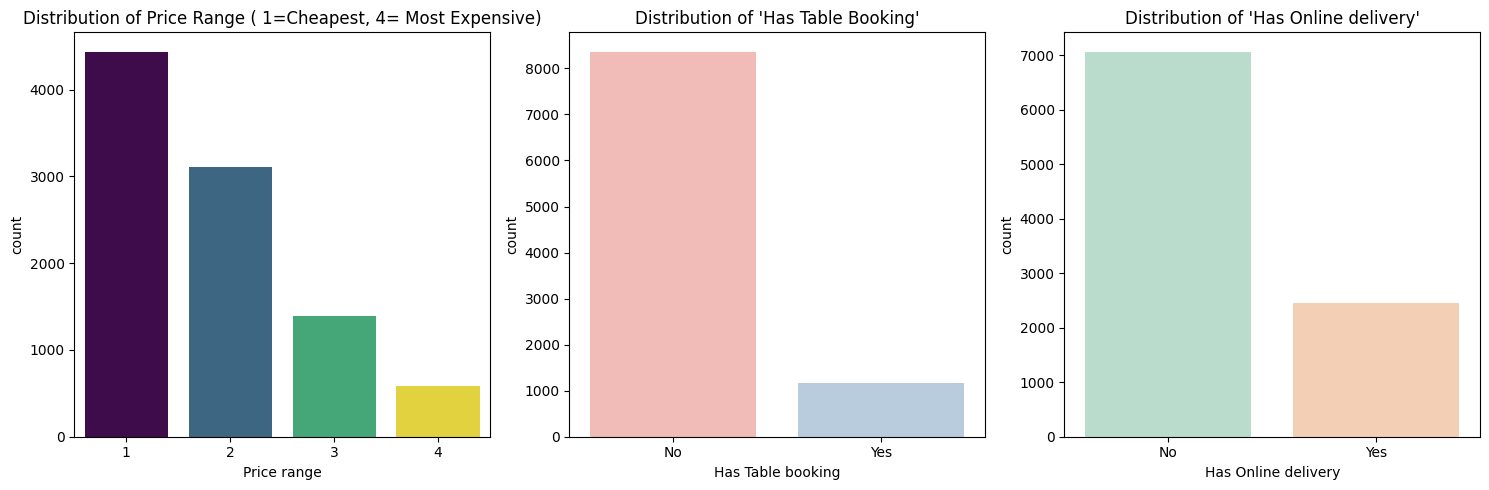

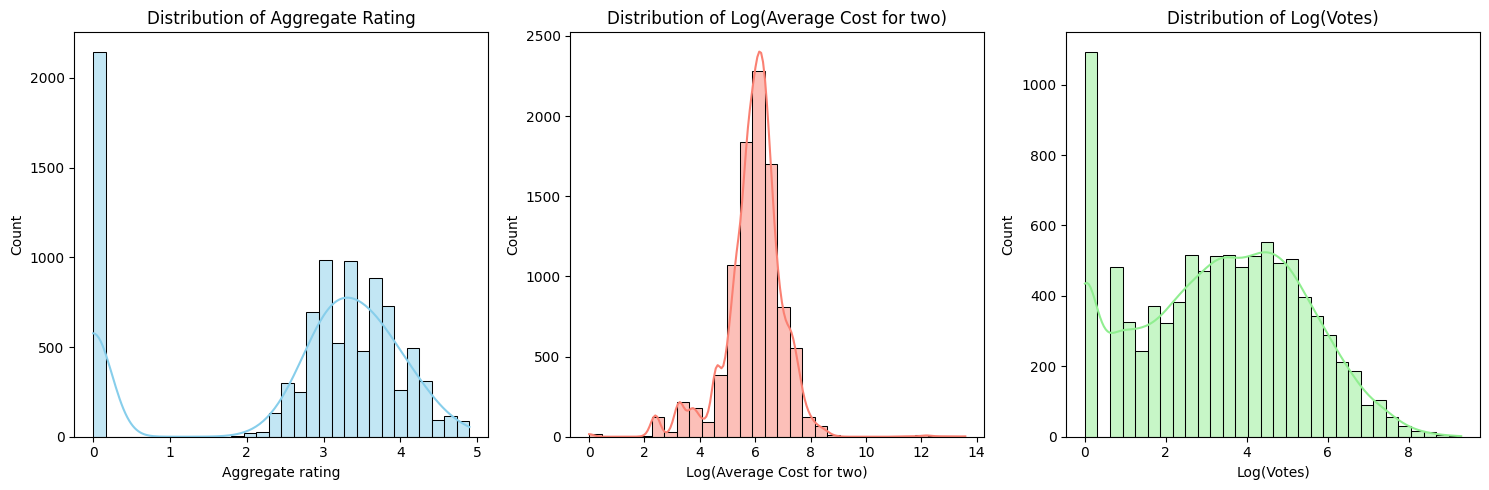

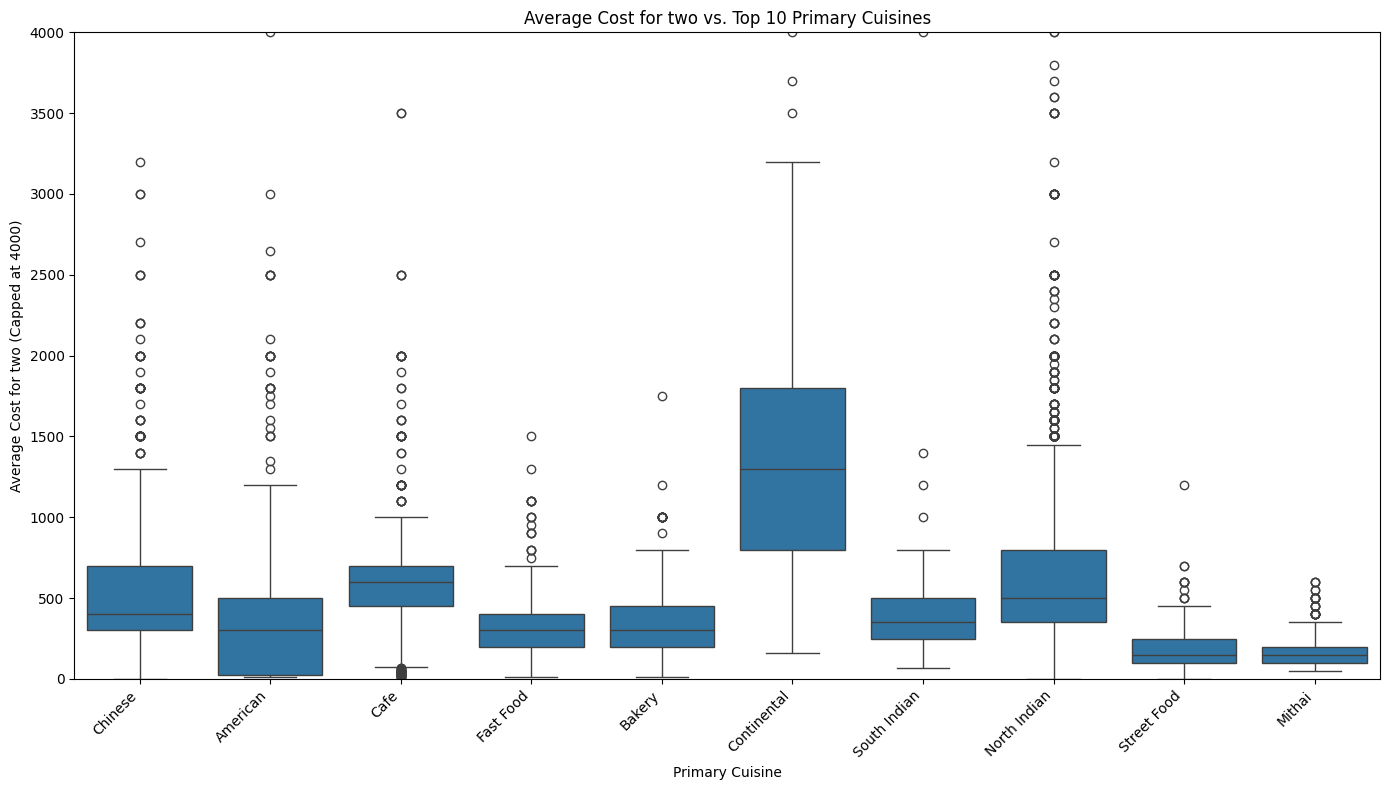

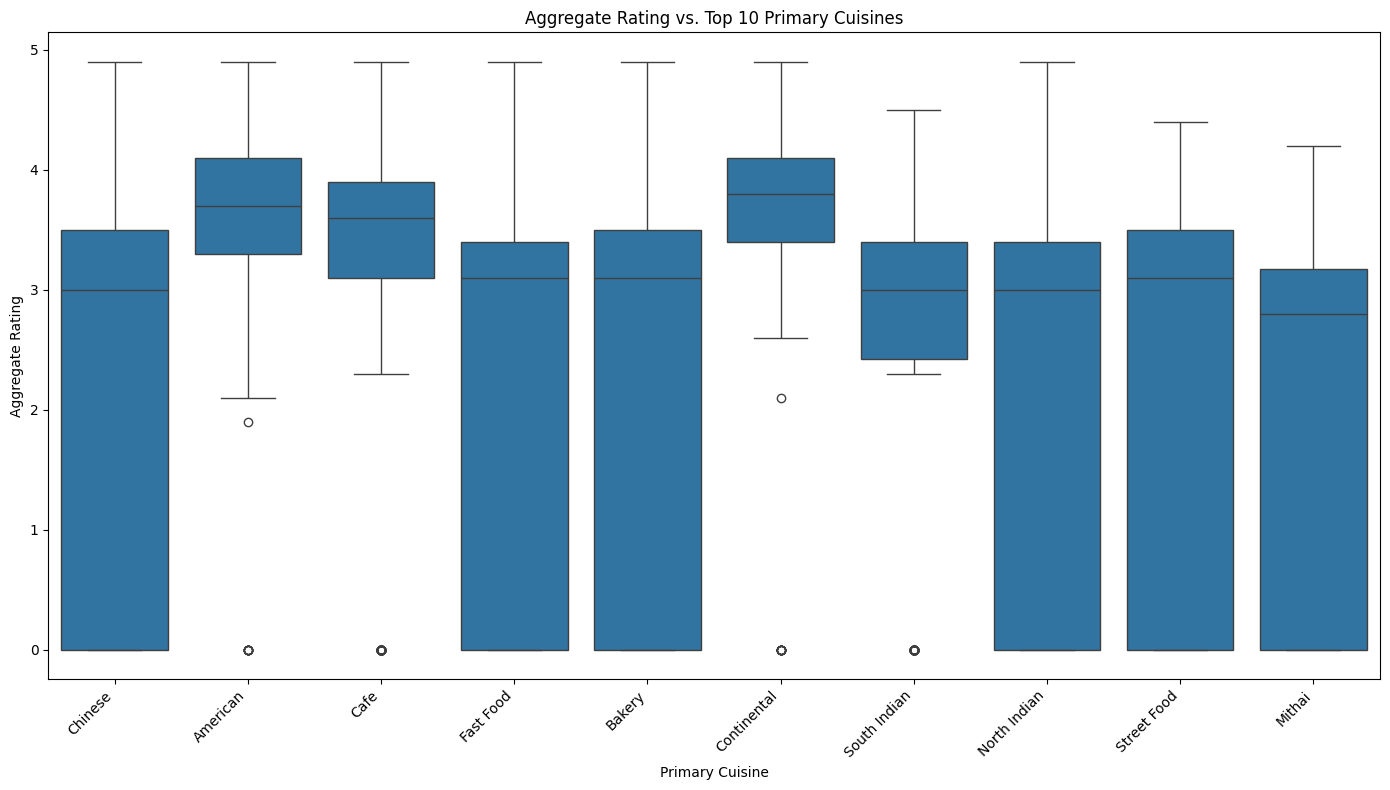

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Exploratory Data Analysis(EDA)")

# 1)Distribution of Categorical/Ordinal Features
plt.figure(figsize=(15,5))
# Distribution of Price Range (Ordinal)
plt.subplot(1, 3, 1)
sns.countplot(x='Price range', data=df_filtered, palette='viridis', hue='Price range', legend = False)
plt.title('Distribution of Price Range ( 1=Cheapest, 4= Most Expensive)')


# Distribution of 'Has Table Booking' (Binary)
plt.subplot(1, 3, 2)
sns.countplot(x='Has Table booking', data=df_filtered, palette='Pastel1', hue= 'Has Table booking', legend = False)
plt.xticks([0, 1], ['No', 'Yes'])
plt.title("Distribution of 'Has Table Booking'")

# Distribution of 'Has Online delivery' (Binary)
plt.subplot(1, 3, 3)
sns.countplot(x='Has Online delivery', data=df_filtered, palette='Pastel2', hue = 'Has Online delivery', legend=False)
plt.xticks([0,1], ['No', 'Yes'])
plt.title("Distribution of 'Has Online delivery'")

plt.tight_layout()
plt.show()

# 2) Distribution of Continuous Features (Votes, Cost, Rating)
plt.figure(figsize=(15,5))

# Distribution of Aggregate Rating
plt.subplot(1, 3, 1)
sns.histplot(df_filtered['Aggregate rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Aggregate Rating')

# Distribution of 'Average Cost for two' (Log Scale due to outliers)
plt.subplot(1, 3, 2)
df_filtered['log_cost'] = np.log1p(df_filtered['Average Cost for two'])
sns.histplot(df_filtered['log_cost'], bins = 30, kde=True, color='salmon')
plt.title('Distribution of Log(Average Cost for two)')
plt.xlabel('Log(Average Cost for two)')

# Distribution of Votes ( Log Scale due to high skewness)
plt.subplot(1, 3, 3)
df_filtered['log_votes'] = np.log1p(df_filtered['Votes'])
sns.histplot(df_filtered['log_votes'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Log(Votes)')
plt.xlabel('Log(Votes)')

plt.tight_layout()
plt.show


# 3) Feature vs Target

# Relationship between Price Range and Target ( Top 10 Cuisines)

top_10_cuisines_names = df_filtered['Primary_Cuisine'].value_counts().head(10).index
df_top_10 = df_filtered[df_filtered['Primary_Cuisine'].isin(top_10_cuisines_names)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='Primary_Cuisine', y='Average Cost for two', data=df_top_10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 4000) # Cap the y-axis to focus on the majority of data points
plt.title('Average Cost for two vs. Top 10 Primary Cuisines')
plt.xlabel('Primary Cuisine')
plt.ylabel('Average Cost for two (Capped at 4000)')
plt.tight_layout()
plt.show()


# Relationship between rating and Target (Top 10 Cuisines)

plt.figure(figsize=(14, 8))
sns.boxplot(x='Primary_Cuisine', y='Aggregate rating', data=df_top_10)
plt.xticks(rotation=45, ha='right')
plt.title('Aggregate Rating vs. Top 10 Primary Cuisines')
plt.xlabel('Primary Cuisine')
plt.ylabel('Aggregate Rating')
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("Data Splitting Results")
print(f"Total filtered dataset size: {len(X)}")
print(f"Training set size (80%): {len(X_train)} records")
print(f"Testing set size (20%): {len(X_test)} records")

Data Splitting Results
Total filtered dataset size: 9521
Training set size (80%): 7616 records
Testing set size (20%): 1905 records


In [7]:
# Training and Evaluation


from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
# n_estimators= 100( 100 Decision Trees)
print(f"Training Random Forest Classifier on {len(Y.unique())} Cuisine Classes")
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Accuracy
overall_accuracy = accuracy_score(Y_test, Y_pred)
print(f"Overall Accuracy of Test Set: {overall_accuracy*100:.2f}%")

# Classification Report
test_labels = np.unique(Y_test)

cuisine_names = encoder2.inverse_transform(test_labels)
print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred,labels = test_labels, target_names=cuisine_names, zero_division=0))

report_dict = classification_report(Y_test, Y_pred, labels= test_labels, target_names=cuisine_names, zero_division=0, output_dict = True)
report_df = pd.DataFrame(report_dict).transpose()
cuisine_rows = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

print("\n Performance of the 20 most popular cuisine \n")
top_20 = cuisine_rows.sort_values(by='support', ascending=False).head(20)
print(top_20[['precision', 'recall', 'f1-score', 'support']].to_markdown(numalign='left', stralign='left'))

print("\n Performance for the 20 least frequent Cuisines \n")
bottom_20 = cuisine_rows.sort_values(by='support', ascending=True).head(20)
print(bottom_20[['precision', 'recall', 'f1-score', 'support']].to_markdown(numalign='left', stralign='left'))


Training Random Forest Classifier on 98 Cuisine Classes
Overall Accuracy of Test Set: 27.40%

Classification Report:

                   precision    recall  f1-score   support

          Afghani       0.00      0.00      0.00         1
         American       0.20      0.21      0.21        56
           Andhra       0.00      0.00      0.00         1
          Arabian       0.00      0.00      0.00         1
            Asian       0.00      0.00      0.00        15
         Assamese       0.00      0.00      0.00         1
           Awadhi       0.00      0.00      0.00         1
              BBQ       0.00      0.00      0.00         4
           Bakery       0.11      0.08      0.09       124
         Bar Food       0.00      0.00      0.00         2
          Bengali       0.00      0.00      0.00         4
        Beverages       0.06      0.06      0.06        16
           Bihari       0.00      0.00      0.00         1
          Biryani       0.17      0.09      0.12       

In [8]:
import pandas as pd

print("\n Overall Performance Summary (Baseline Model) \n")

# Use the pre-computed overall_accuracy variable
print(f"Overall Accuracy of Test Set: {overall_accuracy*100:.2f}%")

# Collect macro and weighted averages from report_dict directly to ensure they are present
summary_metrics_data = {}
if 'macro avg' in report_dict:
    summary_metrics_data['macro avg'] = report_dict['macro avg']
if 'weighted avg' in report_dict:
    summary_metrics_data['weighted avg'] = report_dict['weighted avg']

if summary_metrics_data:
    # Create a DataFrame from the collected summary data
    summary_df_for_display = pd.DataFrame(summary_metrics_data).transpose()
    # Define columns to print and filter for existing ones
    cols_to_print = ['precision', 'recall', 'f1-score', 'support']
    existing_cols = [col for col in cols_to_print if col in summary_df_for_display.columns]
    if existing_cols:
        print(summary_df_for_display[existing_cols].to_markdown(numalign="left", stralign="left"))
    else:
        print("No relevant summary columns found for macro/weighted averages.")
else:
    print("Macro and Weighted averages could not be retrieved from the report dictionary.")

print("\n ---- The large gap between Weighted and Macro F1-Score indicates significant Class Imbalance Bias----")

# Analyze Well-predicted Cuisines(High F1-Scores)
print("\n ------- Succcess Stories ( Top 5 F1=Scores) ------")
success_cuisines = cuisine_rows.sort_values(by='f1-score', ascending=False).head(5)
print(success_cuisines[['precision', 'recall', 'f1-score', 'support']].to_markdown(numalign='left', stralign='left'))

# Analyze poorly predicted cuisines (Lowest F1-Scores)
print("\n ------- Areas of Challenge ( Bottom 5 F1-Scores) ------")
challenge_cuisines = cuisine_rows[cuisine_rows['support'] > 0]
challenge_cuisines = challenge_cuisines.sort_values(by='f1-score', ascending=True).head(5)
print(challenge_cuisines[['precision', 'recall', 'f1-score', 'support']].to_markdown(numalign='left', stralign='left'))

zero_recall_cuisines = cuisine_rows[cuisine_rows['recall'] == 0]
if not zero_recall_cuisines.empty:
  print(" ---- Cuisines with ZERO Recall (Highest Bias Indicator) -----")
  print(zero_recall_cuisines.head(10)[['precision', 'recall', 'f1-score', 'support']].to_markdown(numalign='left', stralign='left'))
else:
  print("\n No Cuisines with zero recall")


 Overall Performance Summary (Baseline Model) 

Overall Accuracy of Test Set: 27.40%
|              | precision   | recall   | f1-score   | support   |
|:-------------|:------------|:---------|:-----------|:----------|
| macro avg    | 0.0774492   | 0.081206 | 0.076991   | 1905      |
| weighted avg | 0.224398    | 0.274016 | 0.240265   | 1905      |

 ---- The large gap between Weighted and Macro F1-Score indicates significant Class Imbalance Bias----

 ------- Succcess Stories ( Top 5 F1=Scores) ------
|                 | precision   | recall   | f1-score   | support   |
|:----------------|:------------|:---------|:-----------|:----------|
| Restaurant Cafe | 1           | 1        | 1          | 1         |
| Sunda           | 0.5         | 1        | 0.666667   | 1         |
| Brazilian       | 0.5         | 0.5      | 0.5        | 4         |
| North Indian    | 0.399128    | 0.611018 | 0.48285    | 599       |
| Kebab           | 0.333333    | 0.5      | 0.4        | 2         |

In [17]:
# Hyperparameter Tuning (Grid Search Cross-Validation)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print(" To overcome the significance class imbalance bias, we choose Optimization ")
print("--- Hyperparameter Tuning (Grid Search) ---")
print("Starting Grid Search... This process may take a few minutes due to the large number of classes and cross-validation.\n\n\n")

# Define the parameter grid to search
param_grid = {
    # Testing two options for the number of trees
    'n_estimators': [100, 200],
    # Testing two specific depths and unlimited depth
    'max_depth': [15, 25, None],
    # Testing two options for minimum split samples
    'min_samples_split': [5, 10]
}

# Initialize the base Random Forest Classifier (the blueprint for tuning)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
# scoring='f1_weighted' is crucial for optimizing performance in our imbalanced dataset
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3, # Using 3-fold cross-validation
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search to the training data
grid_search.fit(X_train, Y_train)

print("\nGrid Search Complete.")

# Store the best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters found: {best_params}")
print(f"Best F1-Weighted Score from Grid Search (CV): {best_score:.4f}")

 To overcome the significance class imbalance bias, we choose Optimization 
--- Hyperparameter Tuning (Grid Search) ---
Starting Grid Search... This process may take a few minutes due to the large number of classes and cross-validation.



Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Grid Search Complete.
Best Hyperparameters found: {'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 100}
Best F1-Weighted Score from Grid Search (CV): 0.2591


In [15]:
# Evaluation of Hypertuned model

from sklearn.metrics import classification_report
import pandas as pd

# 1. Generate predictions using the best tuned model
Y_pred_tuned = best_rf_model.predict(X_test)

# 2. Generate the full classification report
report_tuned = classification_report(
    Y_test,
    Y_pred_tuned,
    labels=test_labels,
    target_names=cuisine_names,
    zero_division=0,
    output_dict=True
)

report_tuned_df = pd.DataFrame(report_tuned).transpose()
cuisine_rows_tuned = report_tuned_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

print("--- Final Tuned Model Evaluation ---")

# Print Summary Metrics
summary_metrics_tuned = report_tuned_df.loc[['weighted avg', 'macro avg'], ['precision', 'recall', 'f1-score', 'support']]
print("\nOverall Performance Summary (Tuned Model):")
print(summary_metrics_tuned.to_markdown(numalign="left", stralign="left"))

--- Final Tuned Model Evaluation ---

Overall Performance Summary (Tuned Model):
|              | precision   | recall    | f1-score   | support   |
|:-------------|:------------|:----------|:-----------|:----------|
| weighted avg | 0.256072    | 0.334908  | 0.265533   | 1905      |
| macro avg    | 0.101731    | 0.0891464 | 0.0841448  | 1905      |


In [14]:
# Extract and visualize feature importance from the tuned model
feature_importances = pd.Series(
    best_rf_model.feature_importances_,
    # X_test.columns holds the names of the 6 features we used
    index=X_test.columns
).sort_values(ascending=False)

print("\n--- Feature Importance Analysis ---")
print("Top Features Driving Cuisine Classification:")
print(feature_importances.head(6).to_markdown(numalign="left", stralign="left"))


--- Feature Importance Analysis ---
Top Features Driving Cuisine Classification:
|                      | 0         |
|:---------------------|:----------|
| Votes                | 0.359598  |
| Average Cost for two | 0.28131   |
| Aggregate rating     | 0.242986  |
| Price range          | 0.0572701 |
| Has Online delivery  | 0.0400847 |
| Has Table booking    | 0.0187511 |


In [20]:
Conclusion="""
Project Conclusion: Final Diagnosis and Future Strategy
  The current modeling phase, culminating in Hyperparameter Tuning , has reached its analytical
  conclusion: the model has failed its primary objective due to data limitations.

Proof of Failure
  The final evaluation confirmed a Macro F1-score of 0.0841. This score is unacceptably low,
  demonstrating the model's catastrophic inability to generalize across the ~ 90 unique cuisine classes.

The Root Cause: Feature Coarseness
  The failure is not the result of poor modeling but of insufficient features. The six simple, high-level
  features (Rating, Cost, etc.) are only capable of identifying the style of a restaurant.  They entirely
  lack the granular detail necessary to differentiate between two similarly styled rare cuisines, causing
  the model to default to predicting the most frequent (majority) class.

Final Recommendation
  To achieve a viable, high-performing cuisine classification model, the project must implement Feature Augmentation.
  The crucial next step is to leverage the detailed, ignored data: the raw text in the Cuisines column.

Future Work:
  Use Term Frequency-Inverse Document Frequency (TF-IDF) to convert the raw text into hundreds of numerical features.
  This will provide the necessary information to overcome the data bias and finally achieve an acceptable Macro F1-score.
"""


print(Conclusion)


Project Conclusion: Final Diagnosis and Future Strategy
  The current modeling phase, culminating in Hyperparameter Tuning , has reached its analytical 
  conclusion: the model has failed its primary objective due to data limitations.
  
Proof of Failure
  The final evaluation confirmed a Macro F1-score of 0.0841. This score is unacceptably low, 
  demonstrating the model's catastrophic inability to generalize across the ~ 90 unique cuisine classes.
    
The Root Cause: Feature Coarseness
  The failure is not the result of poor modeling but of insufficient features. The six simple, high-level
  features (Rating, Cost, etc.) are only capable of identifying the style of a restaurant.  They entirely 
  lack the granular detail necessary to differentiate between two similarly styled rare cuisines, causing 
  the model to default to predicting the most frequent (majority) class.
      
Final Recommendation
  To achieve a viable, high-performing cuisine classification model, the project mus